## Limpieza de los datos

### Importación BBDD de MySQL

In [ ]:
# instalacion de libreria para hacer la conexión con SQL Alchemy:
#pip install SQLAlchemy

In [ ]:
# Conectar con MySQL usando SQLAlchemy
from sqlalchemy import create_engine
import pandas as pd

# Detalles de la conexión a la base de datos
host = '212.227.90.6'
database = 'Equip_10'
user = 'Equipo10'
password = 'E1q2u3i4p5o10'

# Crear la cadena de conexión para SQLAlchemy
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

try:
    # Conectar a la base de datos
    connection = engine.connect()
    print("Conectado al servidor MySQL usando SQLAlchemy")

    # Cargar la tabla tourist_accommodation usando pandas y SQLAlchemy
    df = pd.read_sql_table('Tourist_Accommodation', connection)
    print(f"Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.")

except Exception as e:
    print(f"Error al conectar o leer la tabla: {e}")

finally:
    # Cerrar la conexión
    if 'connection' in locals() and connection:
        connection.close()
        print("Conexión cerrada")

Conectado al servidor MySQL usando SQLAlchemy
Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.
Conexión cerrada


### Eliminación de casos duplicados en la FK 'apartment_id': 

Creación de un df que solo contenga los casos duplicados para poderlos examinar

In [ ]:
# Suponiendo que tu DataFrame se llama 'df'
df_duplicados = df[df.duplicated(subset=['apartment_id'], keep=False)].copy()

Para la eliminación de los casos duplicados en 'apartment_id' hemos usado la variable 'insert_date' quedandonos con la fecha más moderna y eliminando el resto de registros repetidos.

In [ ]:
# Transformar la variable temporal a datetime especificando el formato
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

# Ordena el DataFrame por 'apartment_id' y luego por 'insert_date' de forma descendente
df_ordenado = df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])

# Elimina los duplicados de 'apartment_id', quedándonos con el primero (el más reciente por el ordenamiento)
df_sin_duplicados = df_ordenado.drop_duplicates(subset=['apartment_id'], keep='first').copy()

# Si quieres resetear el índice del DataFrame resultante
df_sin_duplicados = df_sin_duplicados.reset_index(drop=True)

print(f"Tamaño del DataFrame original: {len(df)}")
print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")

Tamaño del DataFrame original: 7001
Tamaño del DataFrame sin duplicados: 6733


### Eliminación de datos nulls y transformación de variables:

#### Transformación de variables temporales:

In [ ]:
# Convertir las variables temporales a datetime:
df_sin_duplicados['first_review_date'] = pd.to_datetime(df_sin_duplicados['first_review_date'], format='%d/%m/%Y')
df_sin_duplicados['last_review_date'] = pd.to_datetime(df_sin_duplicados['last_review_date'], format='%d/%m/%Y')

#### Transformación las variables 'bathrooms','bedrooms' y 'beds'
- Para poder poner las variables con el formato adecuado primero se ha hacer un tratamiendo de los datos nulls.
- Se ha imputado el valor de la mediana de los nulls usando otras variables como referencia para crear grupos homogeneos.

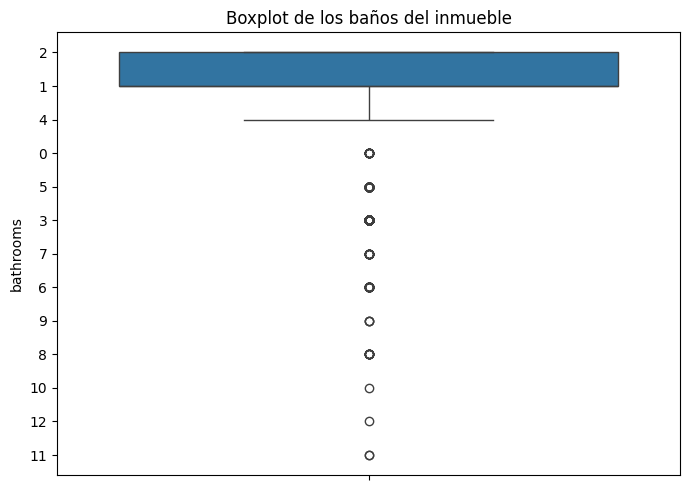

In [ ]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bathrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de los baños del inmueble')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Primero, convierte la columna 'bathrooms' a numérico, los errores se convierten a NaN
df_sin_duplicados['bathrooms'] = pd.to_numeric(df_sin_duplicados['bathrooms'], errors='coerce')

# Calcula la mediana de 'bathrooms' por cada número de 'accommodates'
mediana_bathrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bathrooms'].median()

# Imputa los valores nulos en 'bathrooms' usando la mediana correspondiente al número de 'accommodates'
def imputar_bathrooms(row):
    if pd.isnull(row['bathrooms']):
        return mediana_bathrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bathrooms'].median()) # Si no hay mediana para ese 'accommodates', usa la mediana general
    return row['bathrooms']

df_sin_duplicados['bathrooms'] = df_sin_duplicados.apply(imputar_bathrooms, axis=1)

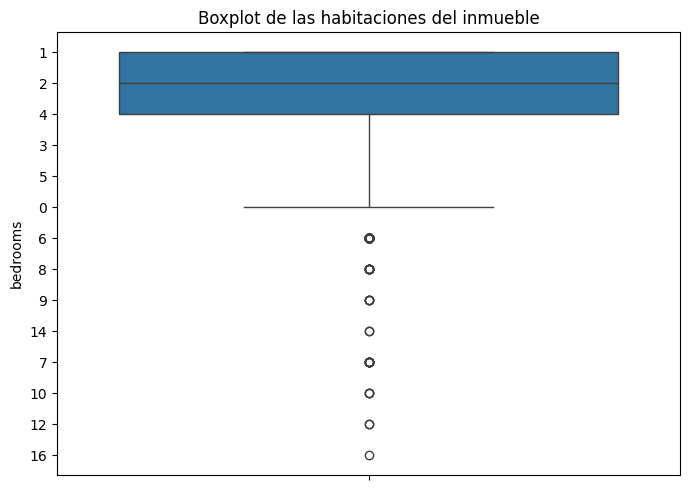

In [ ]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bedrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de las habitaciones del inmueble')
plt.tight_layout()
plt.show()

In [ ]:
# Convertir la columna 'bedrooms' a numérico
df_sin_duplicados['bedrooms'] = pd.to_numeric(df_sin_duplicados['bedrooms'], errors='coerce')

# Calcular la mediana de 'bedrooms' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bedrooms'].median()

# Imputar los valores nulos en 'bedrooms'
def imputar_bedrooms(row):
    if pd.isnull(row['bedrooms']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bedrooms'].median())
    return row['bedrooms']

df_sin_duplicados['bedrooms'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

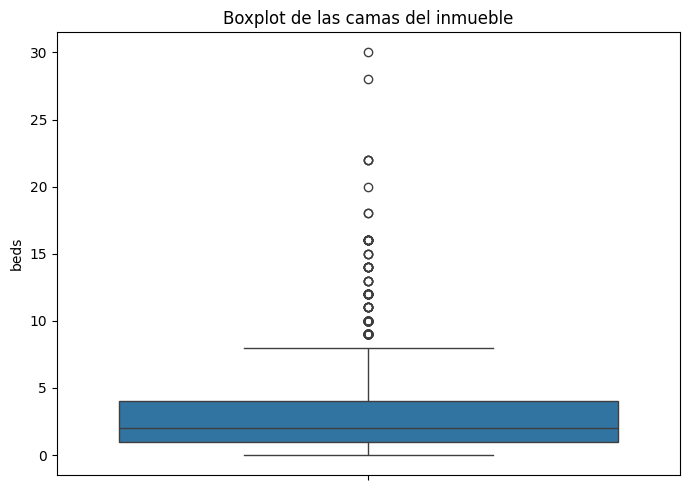

In [ ]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['beds'])
plt.xticks(rotation=45)
plt.title('Boxplot de las camas del inmueble')
plt.tight_layout()
plt.show()

In [ ]:
# Calcular la mediana de 'beds' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['beds'].median()

# Imputar los valores nulos en 'beds'
def imputar_bedrooms(row):
    if pd.isnull(row['beds']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['beds'].median())
    return row['beds']

df_sin_duplicados['beds'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

Para poder imputar en la variable 'price' un valor a los datos nulls se han usado las variables 'room_type' y 'city' para calcular la mediana de cada grupo y a esos grupos donde falta price se le ha aplicado la mediana que corresponde

### Imputación de valores en la variable 'price'

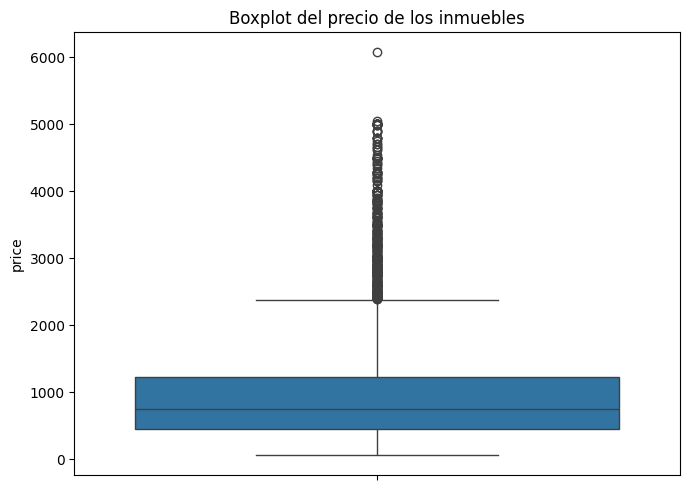

In [ ]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['price'])
plt.xticks(rotation=45)
plt.title('Boxplot del precio de los inmuebles')
plt.tight_layout()
plt.show()

In [ ]:
# Calcular la mediana de 'price' por 'city' y 'room_type'
mediana_price_por_city_roomtype = df_sin_duplicados.groupby(['city', 'room_type'])['price'].median()

# Función para imputar los valores nulos en 'price'
def imputar_price(row):
    if pd.isnull(row['price']):
        try:
            return mediana_price_por_city_roomtype[(row['city'], row['room_type'])]
        except KeyError:
            return df_sin_duplicados['price'].median() # Si no existe la combinación, usa la mediana general
    return row['price']

# Aplicar la imputación
df_sin_duplicados['price'] = df_sin_duplicados.apply(imputar_price, axis=1)

### Imputación de valores nulls en las variables score
 - La variable 'review_scores_rating' está en una escala diferente a las otras variables, así que he igualado su escala a la de las otras variables
 - Esta variable es la puntuación total

In [ ]:
# Dividir entre 10 para ponerla en la misma escala que las otras variables
if df_sin_duplicados['review_scores_rating'].max() > 100:
    df_sin_duplicados['review_scores_rating'] = df_sin_duplicados['review_scores_rating'] / 10

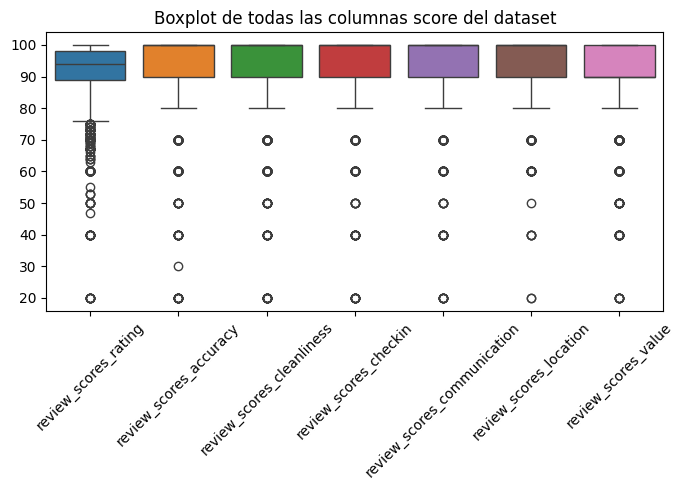

In [ ]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados.iloc[:, 23:30])
plt.xticks(rotation=45)
plt.title('Boxplot de todas las columnas score del dataset')
plt.tight_layout()
plt.show()

In [ ]:
columnas_a_imputar = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'reviews_per_month']

for columna in columnas_a_imputar:
    # Imputar con la mediana del grupo
    df_sin_duplicados[columna] = df_sin_duplicados.groupby(['city', 'room_type'])[columna].transform(lambda x: x.fillna(x.median()))
    # Imputar los nulos restantes con la mediana de la columna completa
    mediana_global = df_sin_duplicados[columna].median()
    df_sin_duplicados[columna] = df_sin_duplicados[columna].fillna(mediana_global)

# Verificar la cantidad de nulos después de la imputación
print(df_sin_duplicados[columnas_a_imputar].isnull().sum())

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64


c:\Users\isana\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\isana\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\isana\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\isana\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\isana\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

### Transformación variable has_availability todos los casos verdadero:

Hemos sustitudo 534 valores nulls imputandoles el valor True y hemos transformado el valor VERDADERO en True

In [ ]:
# Transformar VERDADERO a True
df_sin_duplicados['has_availability'] = df_sin_duplicados['has_availability'].replace('VERDADERO', True)

# Imputacion a valores nulls por True
df_sin_duplicados['has_availability'].fillna(True, inplace=True)

C:\Users\isana\AppData\Local\Temp\ipykernel_31796\1803279718.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sin_duplicados['has_availability'].fillna(True, inplace=True)
C:\Users\isana\AppData\Local\Temp\ipykernel_31796\1803279718.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sin_duplicados['ha

### Datos nulls que siguen existiendo en el dataset:

In [ ]:
# 1. Identificar filas con al menos un valor nulo:
df_sin_duplicados[df_sin_duplicados.isnull().any(axis=1)]

# 2. Obtener el número de valores nulos por columna y filtrar las que tienen al menos uno:
nulos_por_columna = df_sin_duplicados.isnull().sum()

# 3. Eliminar las variables que no tienen nulls de la visualizacion:
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
print("\nNúmero de valores nulos por columna (solo las que tienen nulos):")
print(columnas_con_nulos)


Número de valores nulos por columna (solo las que tienen nulos):
name                         3
description                 27
neighbourhood_district    2658
amenities_list              16
first_review_date         1203
last_review_date          1204
dtype: int64


### Transformación nombre dataset para crear archivo .csv y poder importar el documento en PowerBi

In [ ]:
# Cambio del nombre del dataset
df_tourist = df_sin_duplicados

El código para crear el .csv esta comentado para que no lo cree cada vez que lo ejecutamos entero el script, si se hace algun cambio en el df_tourist se ha de modificar

In [ ]:
# # Exportar el nuevo df como .csv
# nombre_archivo_csv = 'df_tourist.csv'
# df_tourist.to_csv(nombre_archivo_csv, index=False, encoding='utf-8', sep=';', decimal=',')

# # Mensaje sobre la operación realizada
# print(f"El DataFrame se ha guardado exitosamente en '{nombre_archivo_csv}'")